In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [3]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [4]:
adata = sc.read_text("H9_RPE_YOUNG_RawCountMatrix.tsv.gz").T

In [5]:
adata

AnnData object with n_obs × n_vars = 12363 × 33538

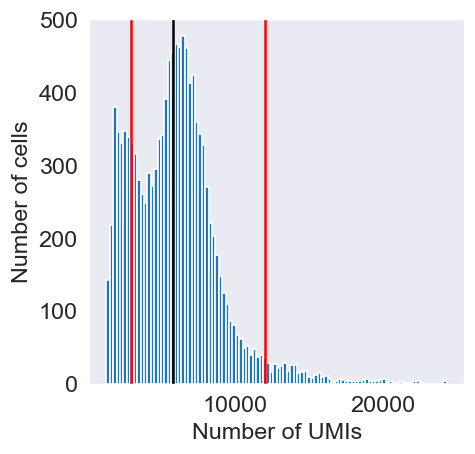

In [6]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(3000, c="r")
plt.axvline(np.median(adata.obs['n_counts']), c="black")
plt.axvline(12000, c="r")
plt.show()

In [7]:
sc.pp.filter_cells(adata, min_counts=3000)
sc.pp.filter_cells(adata, max_counts=12000)

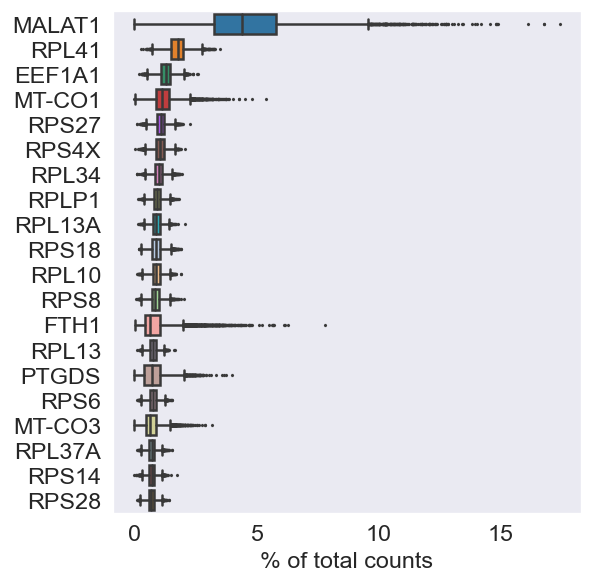

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

9728

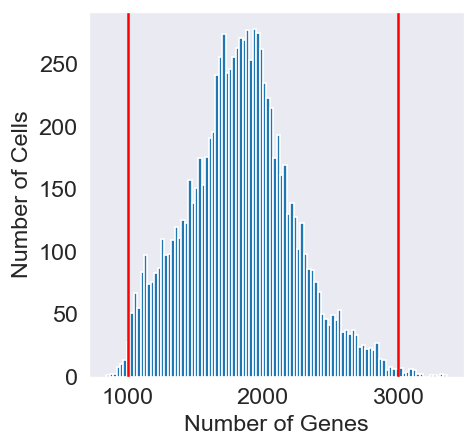

In [10]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(3000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [11]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 3000, :].copy()

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts_filt'] = adata.X.sum(axis=1)

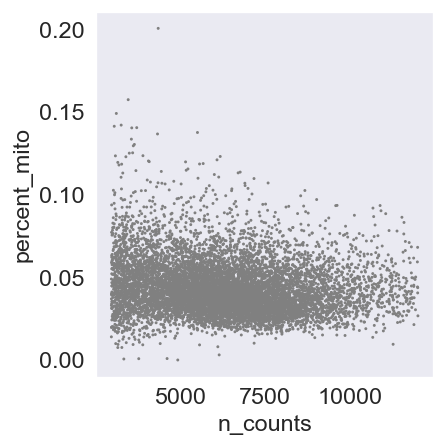

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [14]:
adata = adata[adata.obs['percent_mito'] < 0.15].copy()
adata = adata[adata.obs['percent_mito'] > 0.02].copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 9456 × 33538
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt'

In [16]:
adata_raw = adata.copy()

In [17]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

In [18]:
sc.pp.filter_genes(adata, min_cells=20)

In [19]:
adata

AnnData object with n_obs × n_vars = 9456 × 15433
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells'

In [20]:
sc.pp.normalize_total(adata)

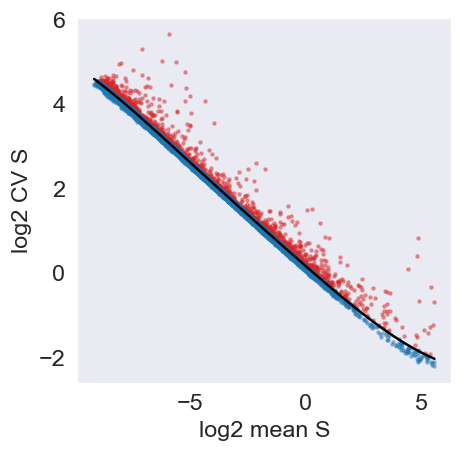

In [21]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.T, N=2000, max_expr_avg=50)

In [22]:
sc.pp.log1p(adata)

In [23]:
adata = adata[:, cv_vs_mean_keep].copy()

In [24]:
sc.pp.regress_out(adata, "percent_mito")
sc.pp.regress_out(adata, "n_counts")

... storing 'phase' as categorical


In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

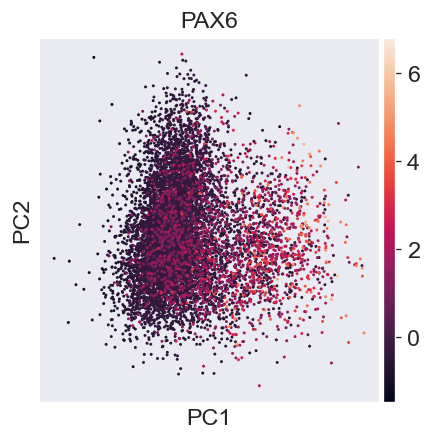

In [27]:
sc.pl.pca(adata, color='PAX6')

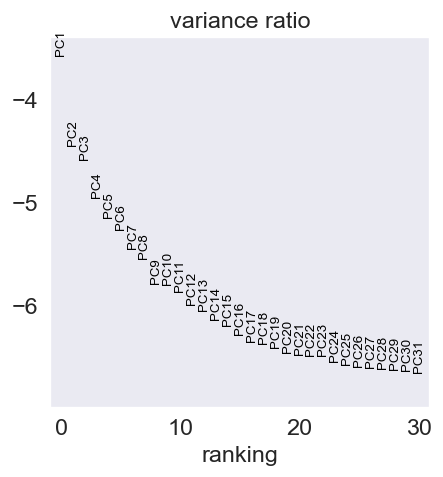

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)

In [30]:
sc.tl.umap(adata, alpha=0.3, min_dist=.5)

In [31]:
sc.tl.louvain(adata, resolution=0.75)

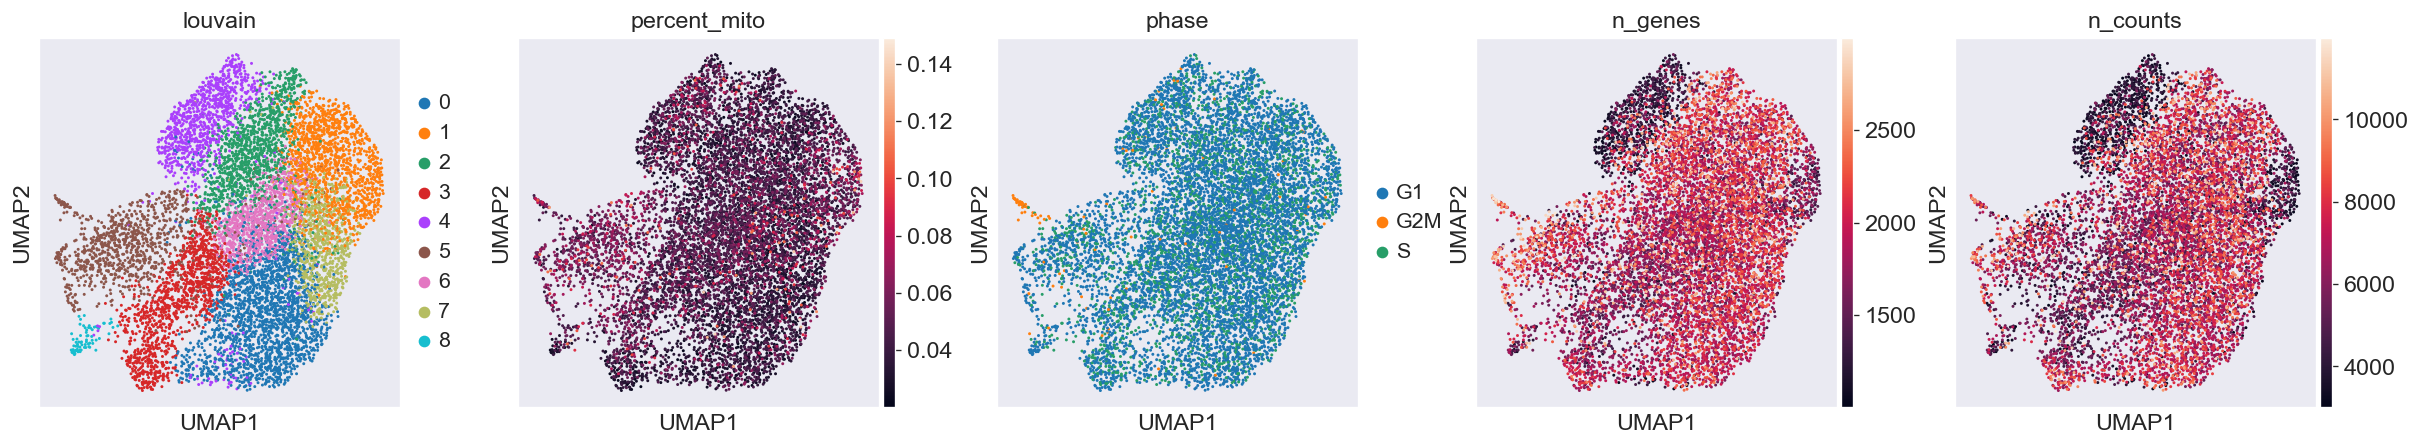

In [32]:
sc.pl.umap(adata, use_raw=False, color=["louvain", "percent_mito", "phase", "n_genes", "n_counts"], ncols=5)

In [33]:
adata.raw = adata_raw

In [34]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=True)

In [35]:
adata_raw_norm = adata_raw.copy()

In [36]:
adata_raw_norm

AnnData object with n_obs × n_vars = 9456 × 33538
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt'

In [37]:
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

In [38]:
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["phase"] = [i for i in adata.obs["phase"]]
adata_raw_norm.obs["louvain"] = [i for i in adata.obs["louvain"]]

... storing 'phase' as categorical
... storing 'louvain' as categorical


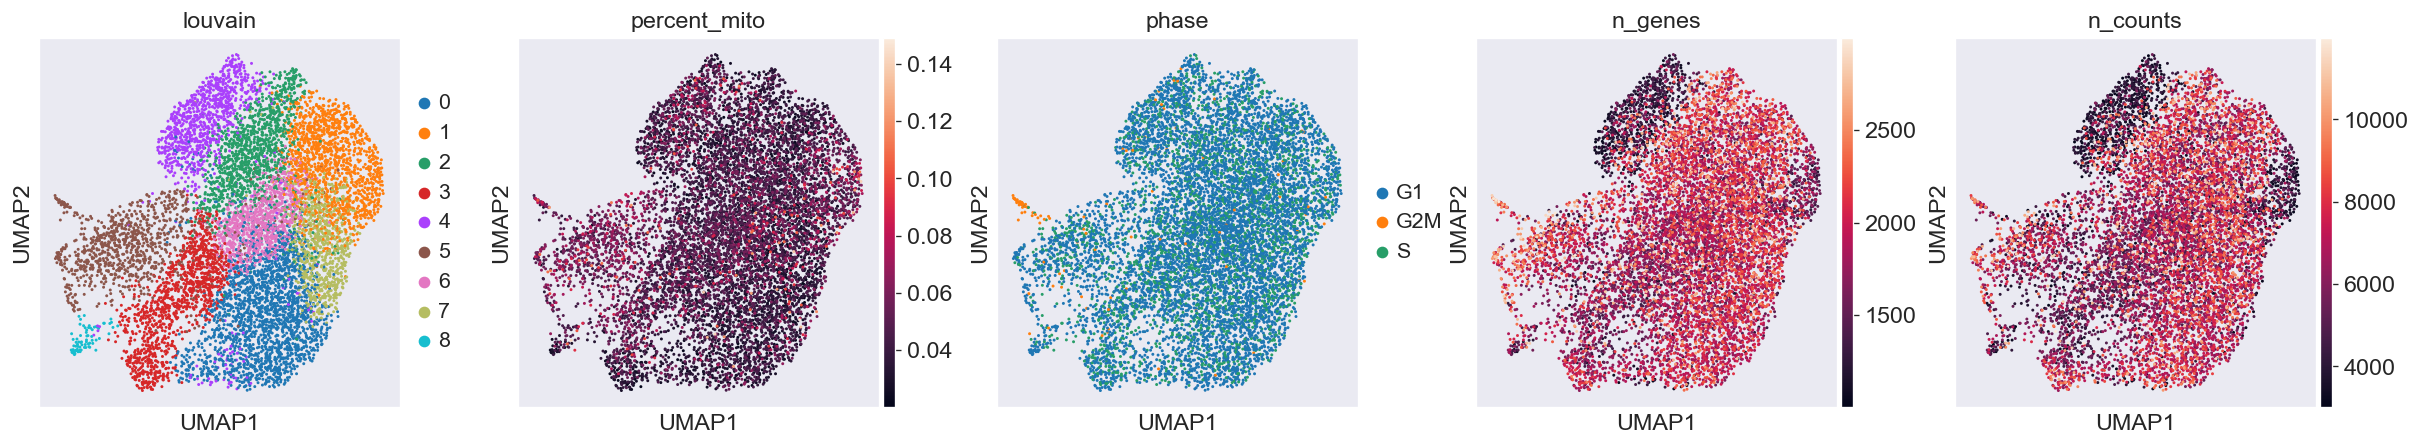

In [39]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "percent_mito", "phase", "n_genes", "n_counts"], ncols=5)

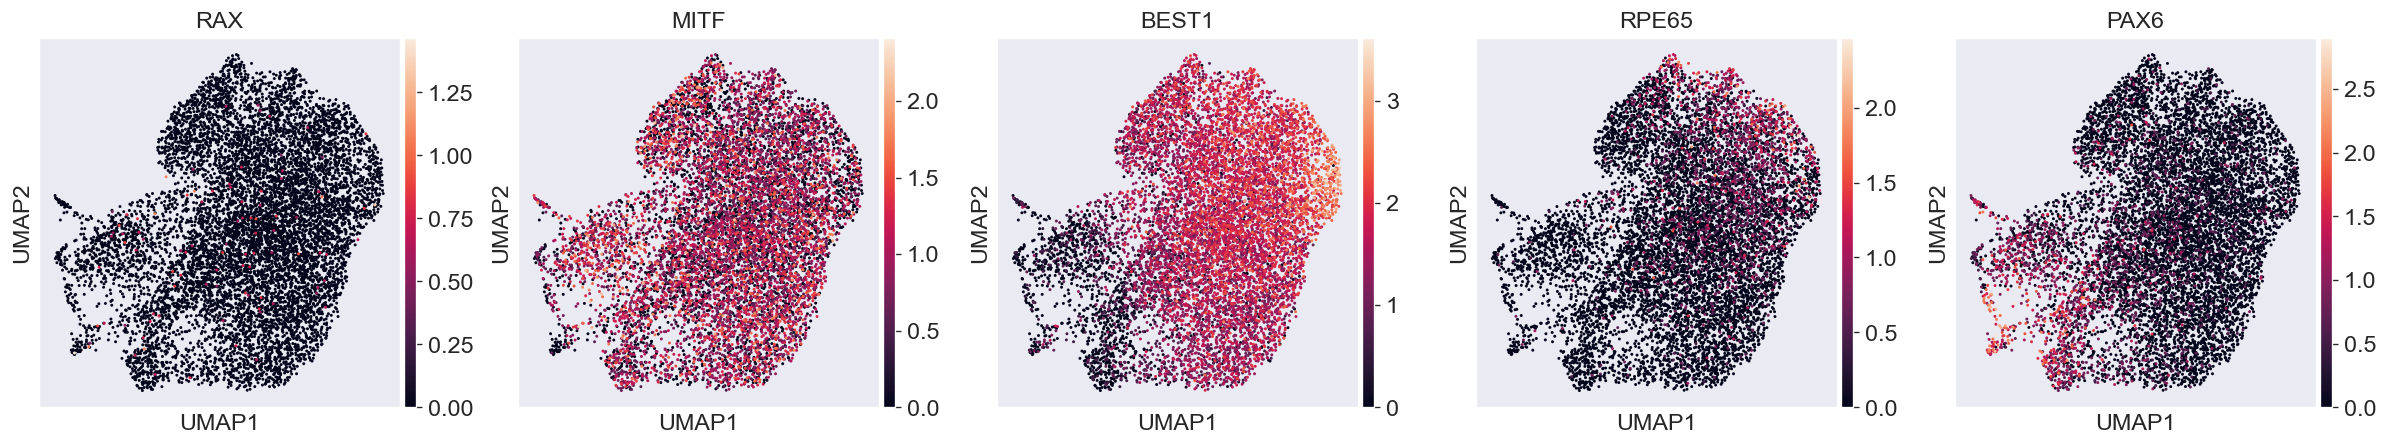

In [40]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["RAX", "MITF", "BEST1", "RPE65", "PAX6"], ncols=5)

In [41]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0         1        2        3        4        5        6         7  \
0    ENO1       TTR   ATP1B1    TFPI2   CTNNB1  HSD17B2   IGFBP5  SH3BGRL3   
1     DCT      CST3   CTNNB1      DCT      NOG   TMSB4X  TSC22D4     WFDC1   
2     CA9  SERPINF1  HNRNPH1     FTH1  HNRNPH1    CALD1    PTGDS      AQP1   
3  RPL18A     BEST1      NOG    CRYAB     AMFR   MT-CYB     GPX4   WFIKKN2   
4   ZFAS1     PTGDS    DAAM1    GNG11    PHKG1     CTSV     CST3  SERPINF1   
5   RPLP2  CRISPLD1   DNAJC3    GNGT1  LRRC75A    UPK3B     RBP1    PRSS33   
6   RPS18     SFRP5     INSR  HSD17B2   ATP1B1     TPM1      DBI  CRISPLD1   
7   RPS23      FRZB     CST3    BNIP3      SET     MYL9    RLBP1     RPL12   
8   RPL32      RBP1   EIF2S3     ACTB     INSR     FTH1    TOMM7     RPL41   
9   RPS12     ITGAV  LRRC75A   IGFBP7  B4GALT1    CRYAB    GNG11      CST3   

         8  
0     PAX6  
1   CRABP1  
2  TSC22D1  
3   CYP1B1  
4   TMSB4X  
5    PCDH9  
6    MGARP  
7    DAPL1  
8   NKAIN4  
9   DPYSL2

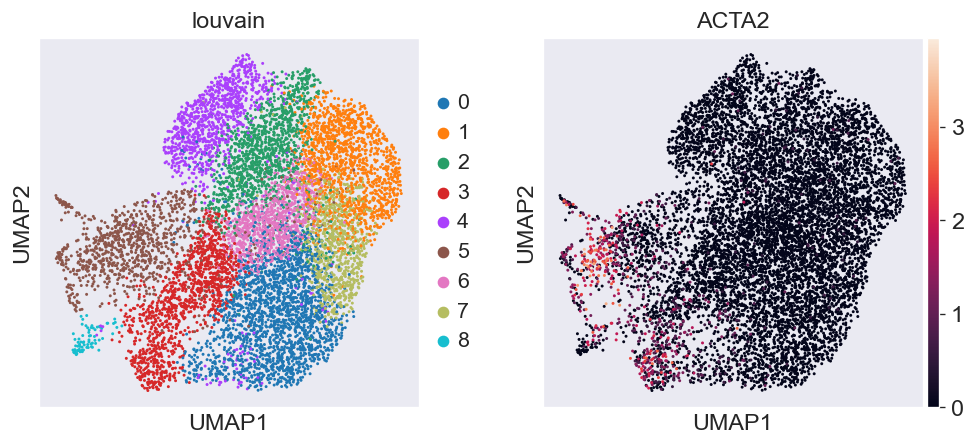

In [42]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "ACTA2"], ncols=5)

In [43]:
l2ct = {'0':"LateRPE", '1':"LateRPE", '2':"LateRPE", 
        '3':"MidRPE", '4':"LateRPE", '5':"EarlyRPE", '6':"LateRPE", '7':"LateRPE", '8':"RetProg"}
adata_raw_norm.obs["cell_type"] = [l2ct[i] for i in adata_raw_norm.obs["louvain"]]

... storing 'cell_type' as categorical


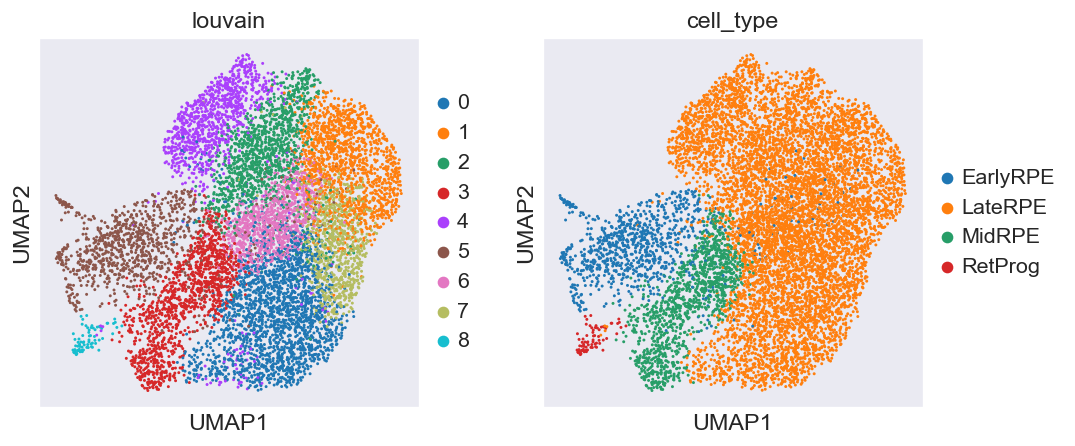

In [44]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "cell_type"], ncols=4)

In [45]:
adata_raw.obs["cell_type"] = adata_raw_norm.obs["cell_type"]

In [46]:
# Subclustering

In [47]:
adata = adata_raw.copy()

In [48]:
adata = adata[adata.obs["cell_type"]=="EarlyRPE"].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [49]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [50]:
sc.pp.filter_genes(adata, min_cells=20)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [51]:
adata

AnnData object with n_obs × n_vars = 946 × 11104
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells'

In [52]:
sc.pp.normalize_total(adata)

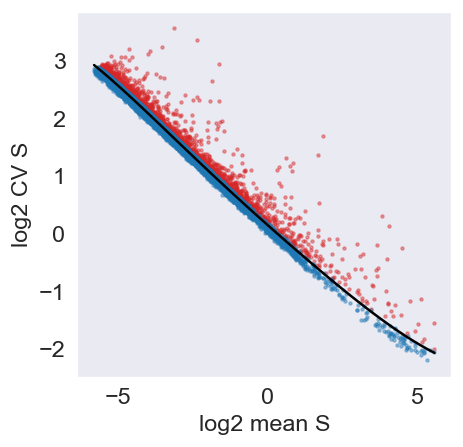

In [53]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.T, N=2000, max_expr_avg=50)

In [54]:
sc.pp.log1p(adata)

In [55]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
sc.pp.regress_out(adata, "percent_mito")
sc.pp.regress_out(adata, "n_counts")

... storing 'phase' as categorical


In [57]:
sc.pp.scale(adata, max_value=10)

In [58]:
sc.tl.pca(adata, svd_solver='arpack')

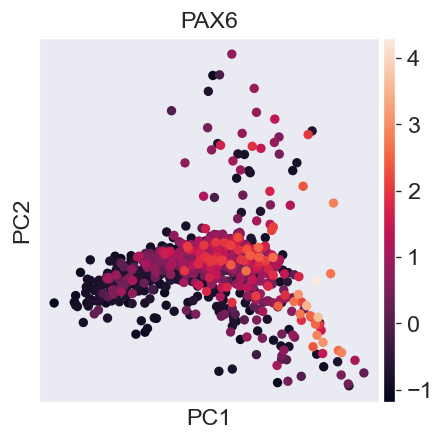

In [59]:
sc.pl.pca(adata, color='PAX6')

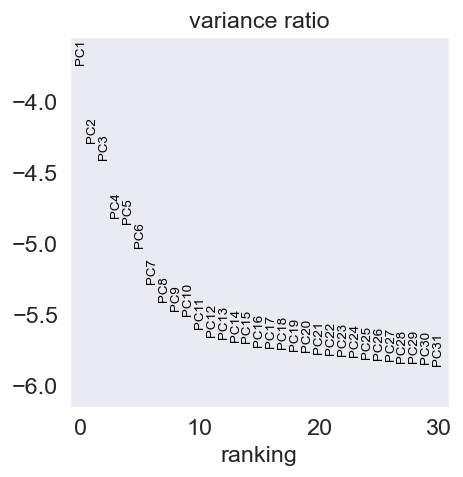

In [60]:
sc.pl.pca_variance_ratio(adata, log=True)

In [61]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)

In [62]:
sc.tl.umap(adata, alpha=0.3, min_dist=.5)

In [63]:
sc.tl.louvain(adata, resolution=1.25)

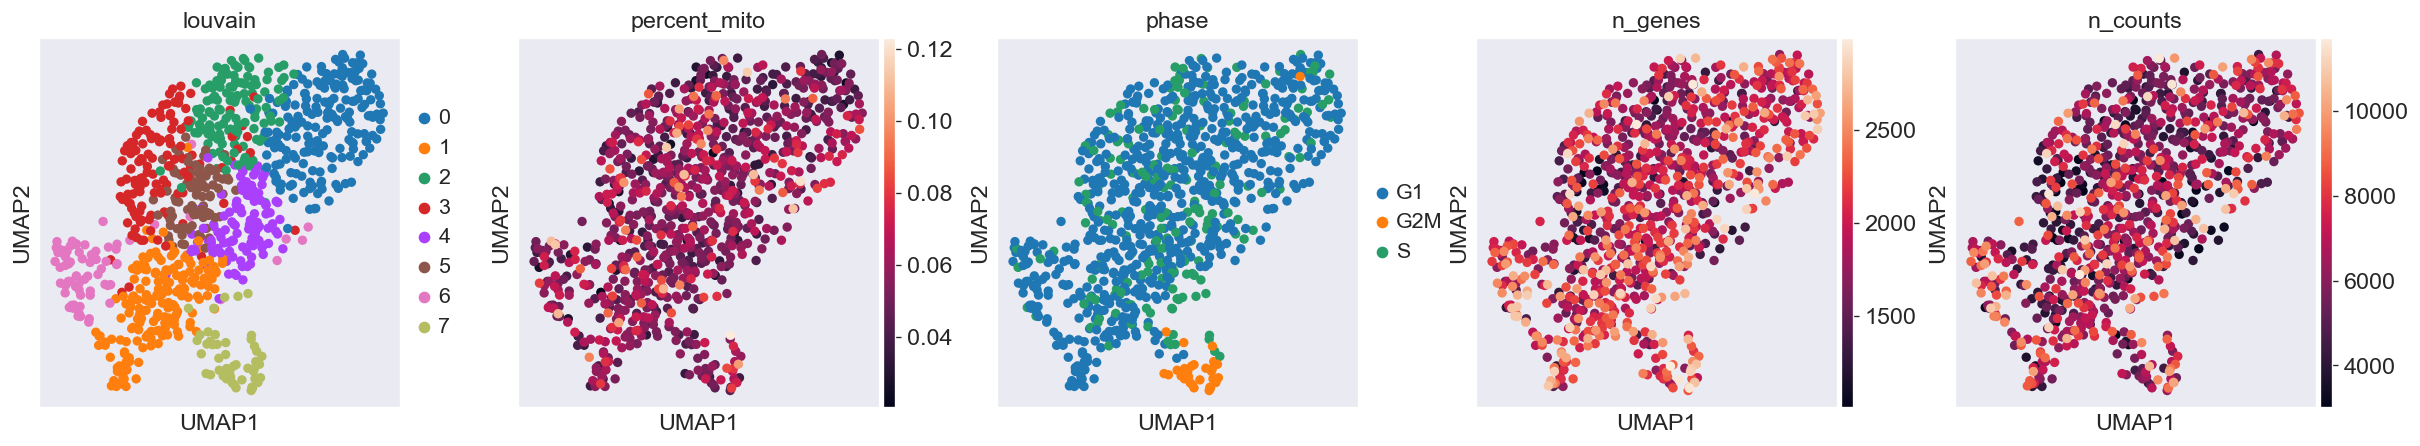

In [64]:
sc.pl.umap(adata, use_raw=False, color=["louvain", "percent_mito", "phase", "n_genes", "n_counts"], ncols=5)

In [65]:
l2ct = {'0':"EarlyRPE", '1':"EMT-RPE", '2':"EarlyRPE", 
        '3':"EarlyRPE", '4':"EarlyRPE", '5':"EarlyRPE", '6':"EMT-RPE", '7':"CyclingRPE"}
adata.obs["cell_type"] = [l2ct[i] for i in adata.obs["louvain"]]

In [66]:
bc2ct = {i:j for i,j in zip(adata.obs.index, adata.obs["cell_type"])}

In [67]:
ct = []
for i, t in zip(adata_raw_norm.obs.index, adata_raw_norm.obs["cell_type"]):
    if i in bc2ct:
        ct.append(bc2ct[i])
    else:
        ct.append(t)
adata_raw_norm.obs["cell_type"] = ct

... storing 'cell_type' as categorical


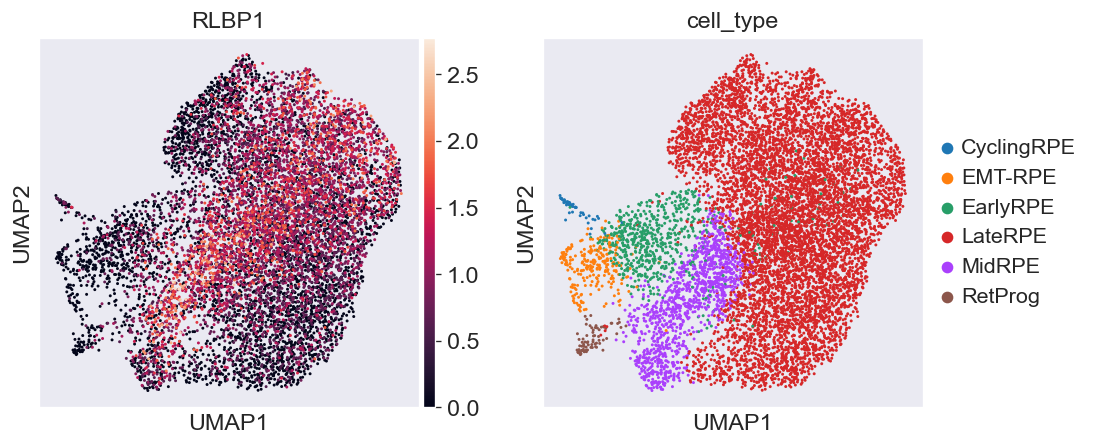

In [68]:
sc.pl.umap(adata_raw_norm, color=["RLBP1", "cell_type"])

In [69]:
adata_raw.obs["cell_type"] = adata_raw_norm.obs["cell_type"]
adata_raw.obsm["X_umap"] = adata_raw_norm.obsm["X_umap"]

In [70]:
adata_raw_norm.obs["cell_type"].value_counts()/len(adata_raw_norm)*100

LateRPE       76.818951
MidRPE        12.394247
EarlyRPE       6.873942
EMT-RPE        2.612098
RetProg        0.782572
CyclingRPE     0.518190
Name: cell_type, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


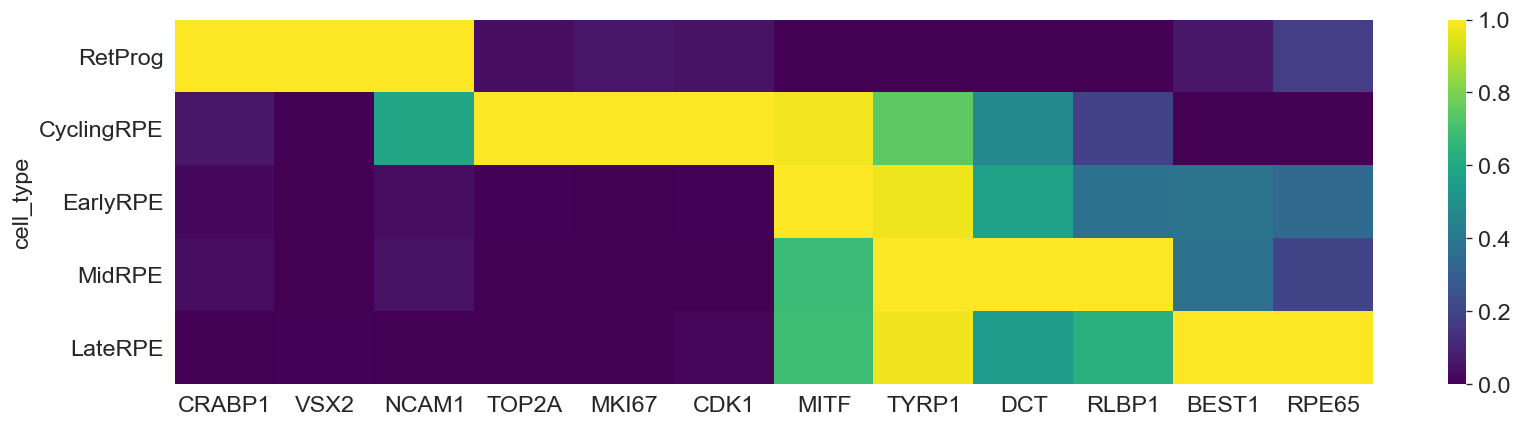

In [71]:
genes = ["PAX6", "CRABP1", "NRN1", "NBL1", "CPAMD8", "SIX6", "VSX2", "NCAM1", "SFRP2",
        "MITF", "DCT", "TYRP1", "TYR", "RLBP1", "BEST1", "RPE65", "TTR", "RGR"]

genes = ["CRABP1", "VSX2", "NCAM1", "TOP2A", "MKI67", "CDK1",
         "MITF", "TYRP1", "DCT",  
        "RLBP1", "BEST1", "RPE65"]
X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[['RetProg', 'CyclingRPE', 'EarlyRPE', 'MidRPE', 'LateRPE', ]]

plt.figure(None, (16, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='viridis')
plt.show()